# Test MonoDecoders: Sequence and Geometry
This notebook replicates the training logic from `learn.py` using the decoder in `mono_decoders.py` for amino acid and geometry prediction.

In [1]:
#use autoreload
%load_ext autoreload
%autoreload 2

In [2]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [ ]:
# Imports
import torch
from torch_geometric.data import DataLoader
import numpy as np
from foldtree2.src import pdbgraph
from foldtree2.src import foldtree2_ecddcd as ft2
from foldtree2.src.mono_decoders import MultiMonoDecoder
import os
import tqdm
import random
import torch.nn.functional as F

In [ ]:
# Set seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data setup
datadir = '../../datasets/foldtree2/'
dataset_path = 'structs_traininffttest.h5'
converter = pdbgraph.PDB2PyG(aapropcsv='./foldtree2/config/aaindex1.csv')
struct_dat = pdbgraph.StructureDataset(dataset_path)
train_loader = DataLoader(struct_dat, batch_size=5, shuffle=True, num_workers=4)

data_sample = next(iter(train_loader))

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Model setup

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
ndim = data_sample['res'].x.shape[1]
ndim_godnode = data_sample['godnode'].x.shape[1]
ndim_fft2i = data_sample['fourier2di'].x.shape[1]
ndim_fft2r = data_sample['fourier2dr'].x.shape[1]

num_embeddings = 20
embedding_dim = 128
hidden_size = 256

encoder = ft2.mk1_Encoder(
	in_channels=ndim,
	hidden_channels=[hidden_size, hidden_size],
	out_channels=embedding_dim,
	metadata={'edge_types': [('res','backbone','res')]},
	num_embeddings=num_embeddings,
	commitment_cost=0.9,
	edge_dim=1,
	encoder_hidden=hidden_size,
	EMA=True,
	nheads=5,
	dropout_p=0.01,
	reset_codes=False,
	flavor='transformer',
	fftin=True
)


print(encoder)
encoder = encoder.to(device)




Seed set to 42


mk1_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_backbone_res): TransformerConv(256, 256, heads=5)
    )
  )
  (norms): ModuleList(
    (0): GraphNorm(256)
  )
  (bn): BatchNorm1d(857, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.01, inplace=False)
  (jk): JumpingKnowledge(cat)
  (ffin): Sequential(
    (0): Linear(in_features=1017, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): GELU(approximate='none')
    (4): DynamicTanh(normalized_shape=256, alpha_init_value=0.5, channels_last=True)
  )
  (lin): Sequential(
    (0): DynamicTanh(normalized_shape=256, alpha_init_value=0.5, channels_last=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): GELU(approximate='none')
    (5): DynamicTanh(normalized_shape=256, alpha_init_va

In [ ]:
use_monodecoder = True  # Set to True to use MultiMonoDecoder, False for Single Decoder
if use_monodecoder == True:
	# MultiMonoDecoder for sequence and geometry
	mono_configs = {
		'sequence_transformer': {
			'in_channels': {'res': embedding_dim},
			'xdim': 20,
			'concat_positions': True,
			'hidden_channels': {('res','backbone','res'): [hidden_size*2] , ('res','backbonerev','res'): [hidden_size*2]},
			'layers': 1,
			'AAdecoder_hidden': [hidden_size, hidden_size, hidden_size//2],
			'amino_mapper': converter.aaindex,
			'flavor': 'sage',
			'nheads': 8,
			'dropout': 0.005,
			'normalize': False,
			'residual': False
		},
		
		'contacts': {
			'in_channels': {'res': embedding_dim, 'godnode4decoder': ndim_godnode, 'foldx': 23 ,  'fft2r': ndim_fft2r, 'fft2i': ndim_fft2i},
			'concat_positions': True,
			'hidden_channels': {('res','backbone','res'): [hidden_size]*8, ('res','backbonerev','res'): [hidden_size]*8, ('res','informs','godnode4decoder'): [hidden_size]*8 , ('godnode4decoder','informs','res'): [hidden_size]*8 },
			'layers': 3,
			'FFT2decoder_hidden': [hidden_size, hidden_size, hidden_size],
			'contactdecoder_hidden': [hidden_size//4, hidden_size//8],
			'nheads': 1,
			'Xdecoder_hidden': [hidden_size, hidden_size,  hidden_size ],
			'metadata': converter.metadata,
			'flavor': 'mfconv',
			'dropout': 0.005,
			'output_fft': False,
			'output_rt':False,
			'normalize': True,
			'residual': False,
			'contact_mlp': False

		}
	}
	
	decoder = MultiMonoDecoder( configs=mono_configs)
else:
	# Single decoder 
	decoder = ft2.HeteroGAE_Decoder(
            in_channels={'res': embedding_dim , 'godnode4decoder': ndim_godnode, 'foldx': 23},
            concat_positions=True,
            hidden_channels={('res','backbone','res'): [hidden_size]*5, ('res','backbonerev','res'): [hidden_size]*5, ('res','informs','godnode4decoder'): [hidden_size]*5 , ('godnode4decoder','informs','res'): [hidden_size]*5},
            layers=5,
            AAdecoder_hidden=[hidden_size, hidden_size, hidden_size//2],
            Xdecoder_hidden=[hidden_size, hidden_size, hidden_size],
            contactdecoder_hidden=[hidden_size//2, hidden_size//2],
            nheads=5,
            amino_mapper=converter.aaindex,
            flavor='sage',
            dropout=0.005,
            normalize=True,
            residual=False,
            contact_mlp=False
        )
decoder = decoder.to(device)
print(decoder)

Seed set to 42


/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Seed set to 42


Initializing decoder for task: sequence_transformer
False True False False False
512 8 1 0.005
Initializing decoder for task: contacts
False False True False False
MultiMonoDecoder(
  (decoders): ModuleDict(
    (sequence_transformer): Transformer_AA_Decoder(
      (input_proj): Sequential(
        (0): Dropout(p=0.005, inplace=False)
        (1): Linear(in_features=384, out_features=512, bias=True)
        (2): GELU(approximate='none')
        (3): Linear(in_features=512, out_features=512, bias=True)
        (4): Tanh()
      )
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
            )
            (linear1): Linear(in_features=512, out_features=2048, bias=True)
            (dropout): Dropout(p=0.005, inplace=False)
            (linear2): Linear(in_features=2048, out

In [ ]:
# Training loop (demo, similar to learn.py)
import time
from collections import defaultdict

num_epochs = 100  # For demonstration, keep small
optimizer = torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

edgeweight = 0.1
xweight = 0.1
fft2weight = 0.01
vqweight = 0.001
clip_grad = True
encoder.device = device
encoder.train()
decoder.train()

MultiMonoDecoder(
  (decoders): ModuleDict(
    (sequence_transformer): Transformer_AA_Decoder(
      (input_proj): Sequential(
        (0): Dropout(p=0.005, inplace=False)
        (1): Linear(in_features=384, out_features=512, bias=True)
        (2): GELU(approximate='none')
        (3): Linear(in_features=512, out_features=512, bias=True)
        (4): Tanh()
      )
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
            )
            (linear1): Linear(in_features=512, out_features=2048, bias=True)
            (dropout): Dropout(p=0.005, inplace=False)
            (linear2): Linear(in_features=2048, out_features=512, bias=True)
            (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((512,), eps=1e-05, elementwise_a

In [ ]:
#get one sample from the dataloader
train_loader = DataLoader(struct_dat, batch_size=1, shuffle=True, num_workers=4)
import random

randint = random.randint(0, len(train_loader) - 1)
print(f"Randomly selected batch index: {randint}")
data_sample = struct_dat[randint]
print(data_sample)
data = data_sample.to(device)
optimizer.zero_grad()
z, vqloss = encoder(data , debug = True)
print('Encoded z shape:', z.shape)

Randomly selected batch index: 912
HeteroData(
  identifier='A0A1I8D3W7',
  AA={ x=[624, 20] },
  R_true={ x=[624, 3, 3] },
  bondangles={ x=[624, 3] },
  coords={ x=[624, 3] },
  fourier1di={ x=[624, 80] },
  fourier1dr={ x=[624, 80] },
  fourier2di={ x=[1, 1300] },
  fourier2dr={ x=[1, 1300] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  plddt={ x=[624, 1] },
  positions={ x=[624, 256] },
  res={ x=[624, 857] },
  t_true={ x=[624, 3] },
  (godnode4decoder, informs, res)={ edge_index=[2, 624] },
  (godnode, informs, res)={ edge_index=[2, 624] },
  (res, backbone, res)={
    edge_index=[2, 1247],
    edge_attr=[623],
  },
  (res, backbonerev, res)={
    edge_index=[2, 1247],
    edge_attr=[623],
  },
  (res, contactPoints, res)={
    edge_index=[2, 4552],
    edge_attr=[4552],
  },
  (res, hbond, res)={
    edge_index=[2, 632],
    edge_attr=[632],
  },
  (res, informs, godnode)={ edge_index=[2, 624] },
  (res, informs, godnode4decoder)={ edge_index=[2, 624] },
  (res, wi

In [ ]:
from Bio import PDB
from Bio.PDB import PDBParser
from foldtree2.src.AFDB_tools import grab_struct

def getCAatoms(pdb_file):
	parser = PDBParser(QUIET=True)
	# Parse the structure
	structure = parser.get_structure('structure', pdb_file)
	ca_atoms = []
	for model in structure:
		for chain in model:
			for residue in chain :
				if 'CA' in residue and PDB.is_aa(residue) :
					ca_atoms.append(residue['CA'])
	return ca_atoms

In [ ]:
#get aa and contacts

from torch_geometric.data import DataLoader , HeteroData
from scipy import sparse
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
#add precision and recall metrics
from sklearn.metrics import precision_recall_curve, average_precision_score

def get_backbone(naa):
	backbone_mat = np.zeros((naa, naa))
	backbone_rev_mat = np.zeros((naa, naa))
	np.fill_diagonal(backbone_mat[1:], 1)
	np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
	return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
	sparsemat = sparse.find(sparsemat)
	return np.vstack([sparsemat[0],sparsemat[1]])

def decoder_reconstruction2aa( ords , device, verbose = False):
	decoder.eval()
	print(ords)
	z = encoder.vector_quantizer.embeddings( ords  ).to('cpu')
	
	edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	godnode_index = np.vstack([np.zeros(z.shape[0]), [ i for i in range(z.shape[0]) ] ])
	godnode_rev = np.vstack([ [ i for i in range(z.shape[0]) ] , np.zeros(z.shape[0]) ])
	#generate a backbone for the decoder
	data = HeteroData()
	
	data['res'].x = z
	backbone, backbone_rev = get_backbone( z.shape[0] )
	backbone = sparse.csr_matrix(backbone)
	backbone_rev = sparse.csr_matrix(backbone_rev)
	backbone = sparse2pairs(backbone)
	backbone_rev = sparse2pairs(backbone_rev)
	positional_encoding = converter.get_positional_encoding( z.shape[0] , 256 )
	print( 'positional encoding shape:', positional_encoding.shape )
	data['res'].batch = torch.tensor([0 for i in range(z.shape[0])], dtype=torch.long)
	data['positions'].x = torch.tensor( positional_encoding, dtype=torch.float32)
	data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
	data[ 'res' , 'backbone_rev' , 'res'].edge_index = torch.tensor(backbone_rev, dtype=torch.long)
	print( data['res'].x.shape )
	#add the godnode
	data['godnode'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder', 'informs', 'res'].edge_index = torch.tensor(godnode_index, dtype=torch.long)
	data['res', 'informs', 'godnode4decoder'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	data['res', 'informs', 'godnode'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	edge_index = edge_index.to( device )
	print( data )
	data = data.to( device )
	allpairs = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	out = decoder( data , allpairs )
	recon_x = out['aa'] if 'aa' in out else None
	edge_probs = out['edge_probs'] if 'edge_probs' in out else None

	print( edge_probs.shape)
	"""
	try:
		amino_map = decoder.decoders['sequence'].amino_acid_indices
	except:
		amino_map = decoder.decoders['sequence_transformer'].amino_acid_indices
		print('Using amino_acid_indices_dict instead of amino_acid_indices')
	revmap_aa = { v:k for k,v in amino_map.items() }
	aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
	
	"""
	aastr = None

	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	if verbose == True:
		print( recon_x )
		print( edge_probs )
	return aastr ,edge_probs

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Epoch 0: 100%|█| 125/125 [02:52<00:


Epoch 0: AA Loss: 1.8041, Edge Loss: 0.8841, VQ Loss: 1.1016 , FFT2 Loss: 0.0000
Encoded z shape: torch.Size([624, 128])
Encoded zdiscrete shape: torch.Size([624])
tensor([16, 16,  8, 16, 16, 16, 16, 16, 16,  7, 16,  7, 16,  8, 16, 16,  7,  7,
         2,  8,  8,  7, 16, 14,  8,  3, 16, 16, 16,  8, 16,  8,  3,  4,  3, 16,
        16,  8,  8, 14, 16,  3,  8, 16, 16, 16,  8, 14,  1, 14, 16, 16, 14,  7,
        14, 16,  4, 14,  8,  7,  1,  8, 14,  4, 16,  1, 16,  4, 15, 16, 16, 16,
         3,  8, 16, 16,  8,  8,  8, 14, 16,  7, 16,  4, 16,  8, 14,  4, 16, 14,
        16, 14,  1,  8, 16, 16,  3, 14,  1,  1,  2,  8, 16,  3, 16,  4,  4, 16,
        16, 16,  7,  0,  3, 16,  0,  4, 16,  8,  8, 16, 14, 15, 14,  8, 16, 16,
         8, 15,  8, 14,  8,  4, 16, 16, 16,  7,  4,  3, 14,  2, 15, 14,  7,  4,
        16,  7, 16,  8, 16, 16,  1, 14, 16, 16,  7,  7, 16,  8,  2,  8,  8, 14,
        14, 16,  8,  4, 16,  8, 16,  8,  1, 16, 16, 16,  7,  3,  4,  2, 14, 14,
         8,  4,  1,  3, 16,  8, 16, 

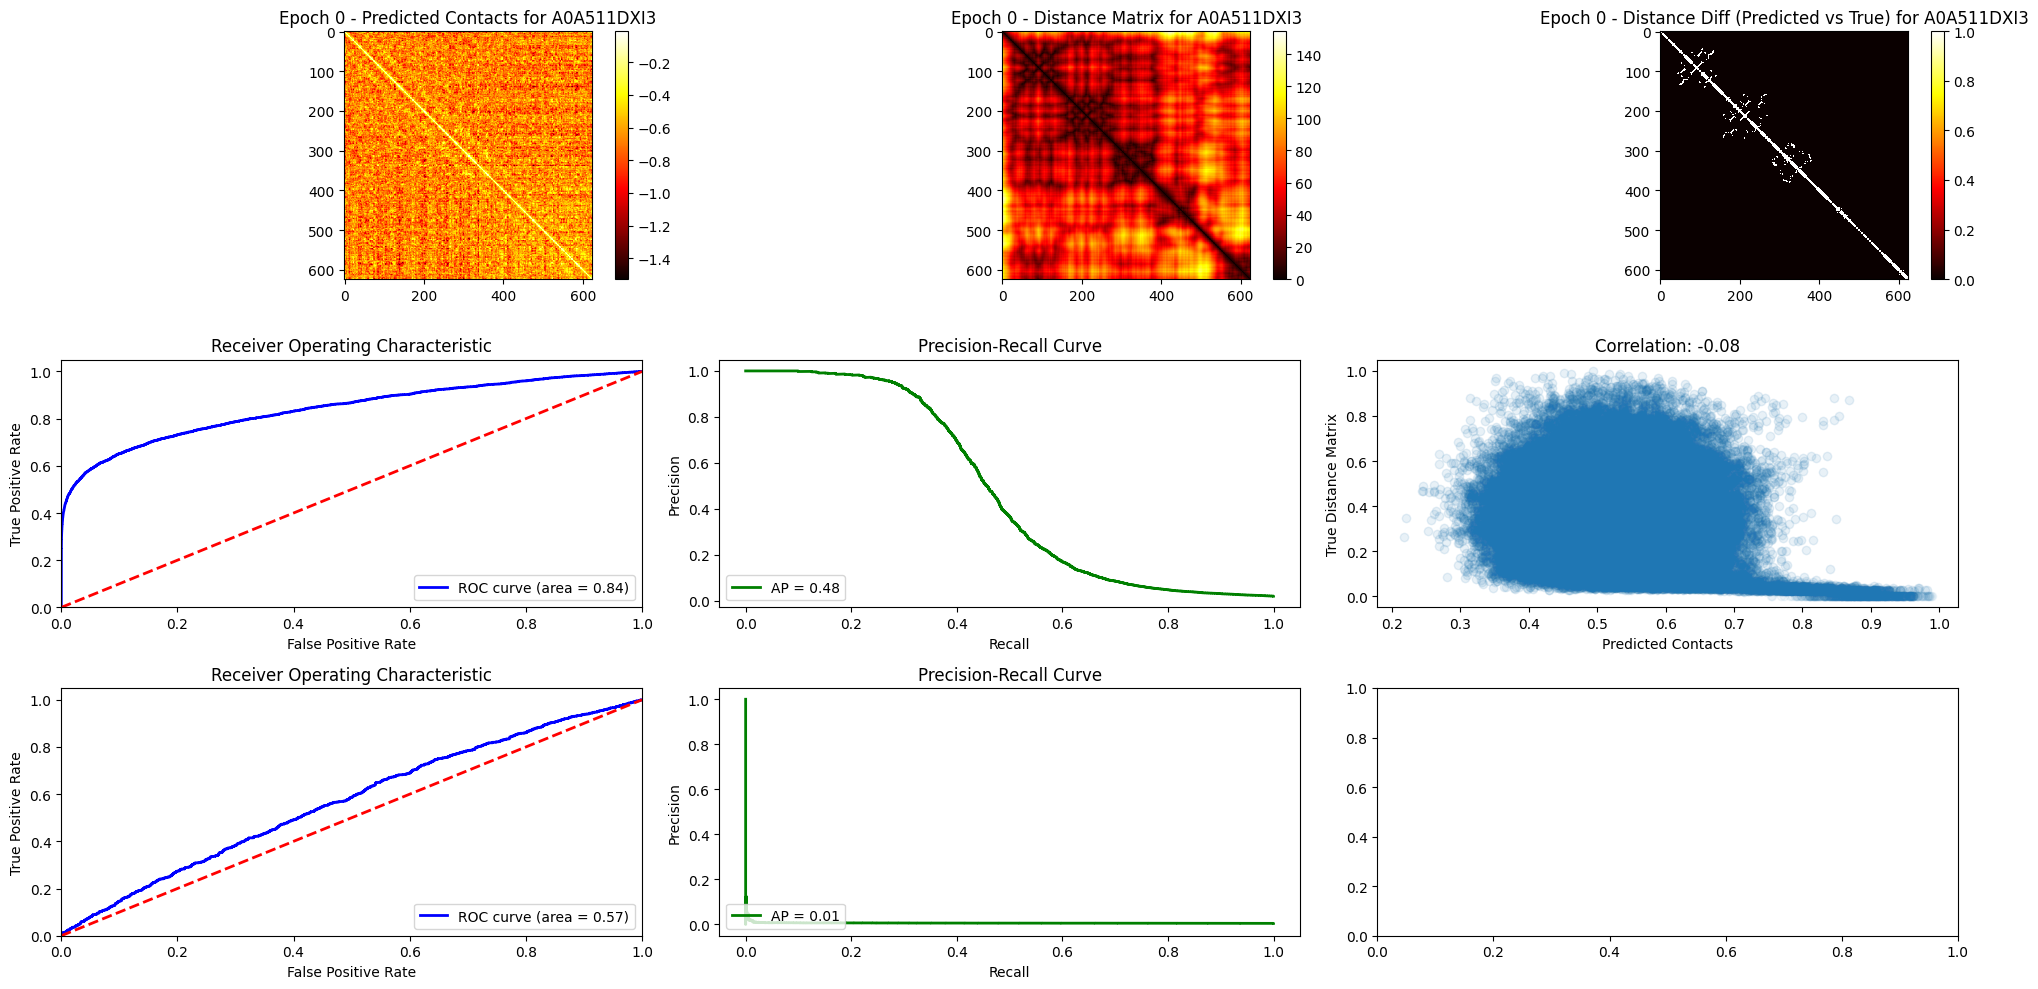

Epoch 1: 100%|█| 125/125 [02:54<00:


Epoch 1: AA Loss: 1.2654, Edge Loss: 0.8831, VQ Loss: 0.4521 , FFT2 Loss: 0.0000
Encoded z shape: torch.Size([624, 128])
Encoded zdiscrete shape: torch.Size([624])
tensor([18, 18,  8, 16, 16, 16, 16, 16, 18,  1, 16,  1, 16,  8, 16, 16,  1,  1,
         2,  8,  8,  1, 16,  9,  8,  3, 16, 16, 16,  8, 16,  8,  3,  2,  3, 16,
        16,  8,  8,  9, 16,  3,  8, 16, 16, 16,  8,  9,  1,  9, 16, 16,  9,  1,
        14, 16,  4, 14,  8,  1,  1,  8, 14,  4, 16,  1, 16, 18, 18, 16, 16, 16,
         3,  8, 16, 16,  8,  8,  8,  9, 16,  1, 16,  4, 16,  8,  9,  4, 16,  9,
        16, 14,  1,  8, 16, 16,  3, 14, 16,  1,  2,  8, 16,  3, 16, 18,  4, 16,
        16, 16,  1,  2,  3, 16,  2,  4, 16,  8,  8, 16,  9, 18, 14,  8, 16, 16,
         8, 18,  8,  9,  8,  4, 16, 16, 16,  1, 18,  3, 14,  2, 18,  9,  1,  4,
        16,  1, 16,  8, 16, 16, 16,  9, 16, 16,  1,  1, 16,  8,  2,  8,  8, 14,
         9, 16,  8,  4, 16,  8, 16,  8, 16, 16, 16, 16,  1,  3,  4,  2,  9, 14,
         8,  4,  1,  3, 16,  8, 16, 

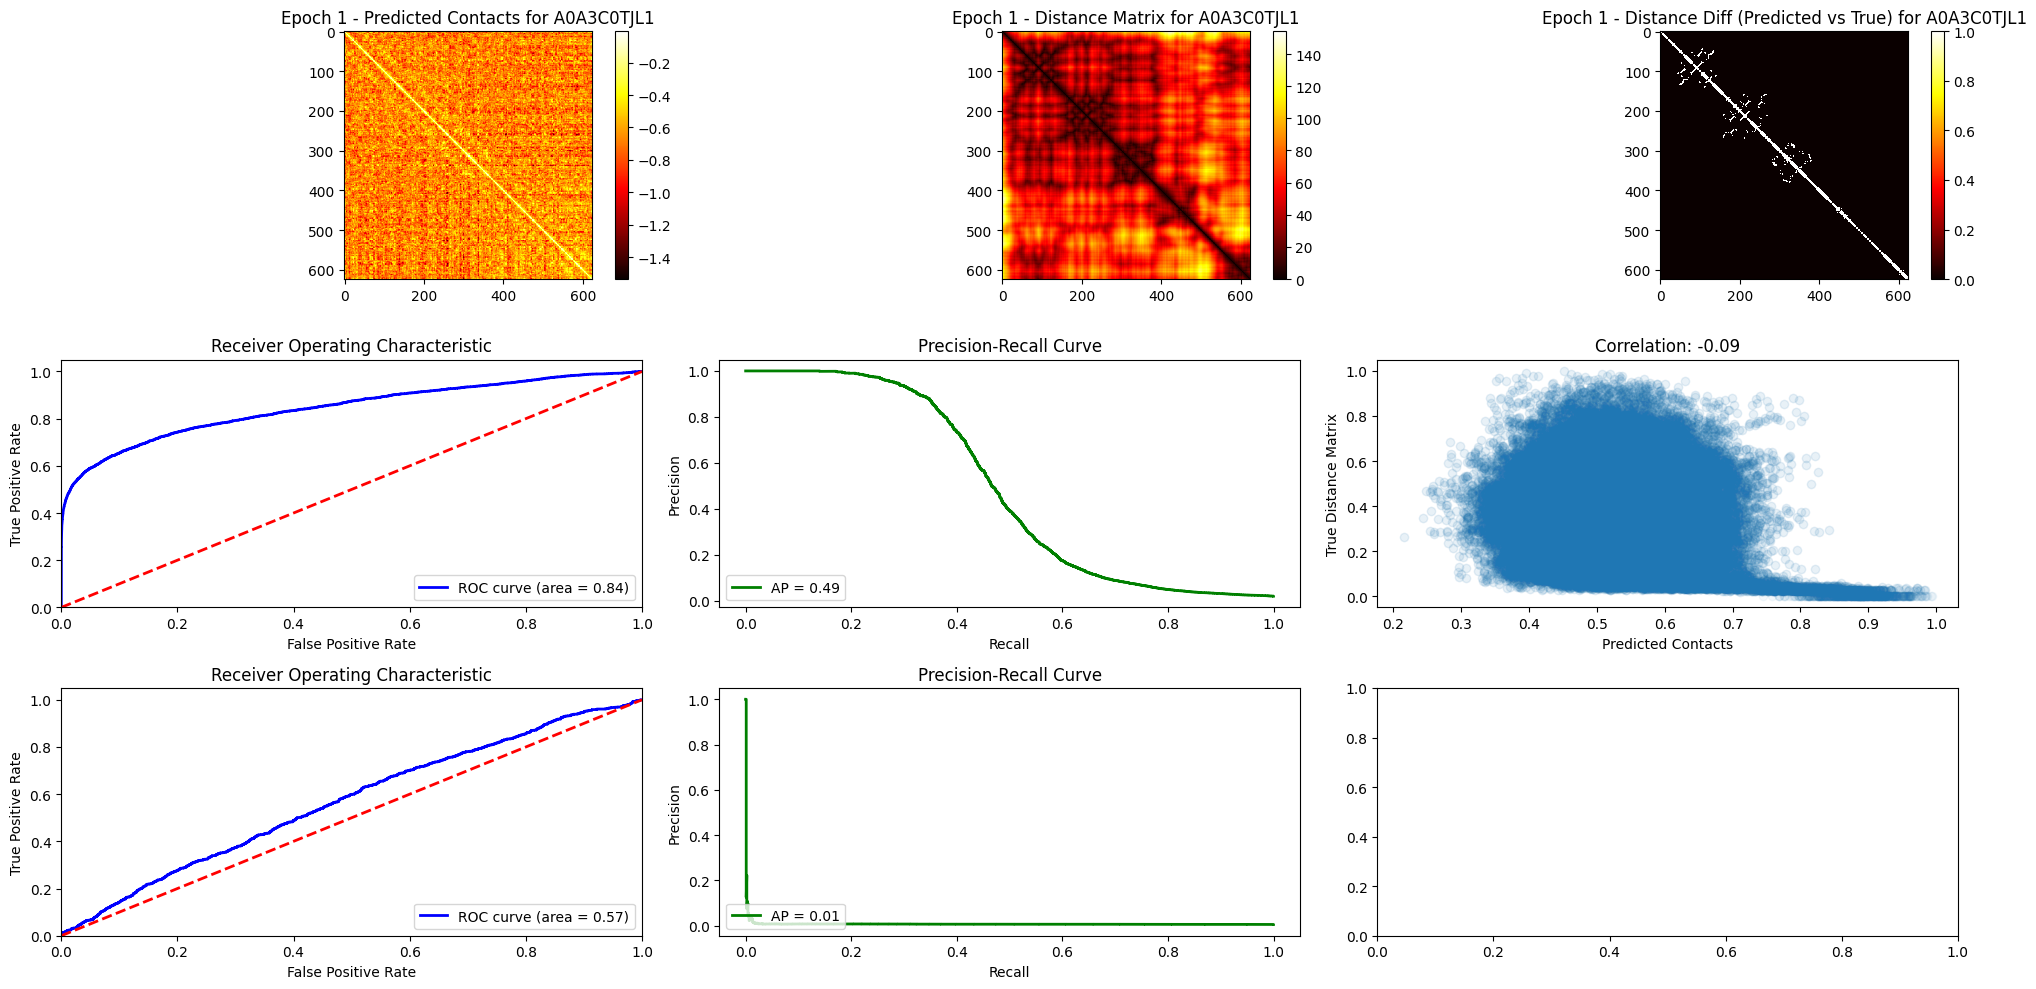

Epoch 2:  63%|▋| 79/125 [01:56<01:1

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7d72c74680>
Traceback (most recent call last):
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
train_loader = DataLoader(struct_dat, batch_size=40, shuffle=True, num_workers=4)
encoder.train()
decoder.train()
from foldtree2.src.losses.losses import recon_loss_diag , aa_reconstruction_loss
for epoch in range(num_epochs):
	total_loss_x = 0
	total_loss_edge = 0
	total_vq = 0
	total_loss_fft2 = 0
	for data in tqdm.tqdm(train_loader, desc=f"Epoch {epoch}"):
		data = data.to(device)
		optimizer.zero_grad()
		z, vqloss = encoder(data)
		data['res'].x = z
		# For demonstration, only sequence and contacts tasks
		out = decoder(data, None)
		recon_x = out['aa'] if isinstance(out, dict) and 'aa' in out else out[0] if isinstance(out, (list, tuple)) else None
		fft2_x = out['fft2pred'] if isinstance(out, dict) and 'fft2pred' in out else out[1] if isinstance(out, (list, tuple)) else None
		# Edge loss: use contactPoints if available
		edge_index = data.edge_index_dict['res', 'contactPoints', 'res'] if hasattr(data, 'edge_index_dict') and ('res', 'contactPoints', 'res') in data.edge_index_dict else None
		if edge_index is not None:
			edgeloss, _ = recon_loss_diag(data, edge_index, decoder, plddt=False, offdiag=False , key = 'edge_probs')
		else:
			edgeloss = torch.tensor(0.0, device=device)
		xloss = aa_reconstruction_loss(data['AA'].x, recon_x)
		if fft2_x is not None:
			fft2loss = F.smooth_l1_loss(torch.cat( [ data['fourier2dr'].x ,data['fourier2di'].x ] ,axis = 1 ) , fft2_x )
		else:
			fft2loss = torch.tensor(0.0, device=device)
		loss = xweight * xloss + edgeweight * edgeloss + vqweight * vqloss + fft2loss* fft2weight

		loss.backward()
		if clip_grad:
			torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
			torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)
		optimizer.step()
		total_loss_x += xloss.item()
		total_loss_edge += edgeloss.item()
		total_loss_fft2 += fft2loss.item()
		total_vq += vqloss.item() if isinstance(vqloss, torch.Tensor) else float(vqloss)
	scheduler.step(total_loss_x)
	print(f"Epoch {epoch}: AA Loss: {total_loss_x/len(train_loader):.4f}, Edge Loss: {total_loss_edge/len(train_loader):.4f}, VQ Loss: {total_vq/len(train_loader):.4f} , FFT2 Loss: {total_loss_fft2/len(train_loader):.4f}")

	encoder.eval()
	decoder.eval()
	
	# predict all vs all contacts for the last sample
	data_sample = data_sample.to(device)
	z, vqloss = encoder(data_sample)
	print('Encoded z shape:', z.shape)
	ords = encoder.vector_quantizer.discretize_z(z.detach())
	zdiscrete = ords[0].detach()
	print('Encoded zdiscrete shape:', zdiscrete.shape)
	
	aastr, edge_probs = decoder_reconstruction2aa( zdiscrete , device, verbose=True)
	#show the distance matrix
	grab_struct(str(data_sample.identifier) , structfolder='tmp/')
	#find the total number of residues
	ca_atoms = getCAatoms( 'tmp/' + str(data_sample.identifier) + '.pdb')
	dist_mat = np.zeros((len(ca_atoms), len(ca_atoms)))
	
	for i, res1 in enumerate(ca_atoms):
		for j, res2 in enumerate(ca_atoms):
			if i < j:
				dist_mat[i, j] = np.linalg.norm(res1.coord - res2.coord)
	dist_mat += dist_mat.T  # Make it symmetric
	np.fill_diagonal(dist_mat, 0)
	
	ndistmat = dist_mat.copy()
	ndistmat[dist_mat>10 ] = 0
	ndistmat[dist_mat<=10 ] = 1

	fig, axs = plt.subplots(3, 3, figsize=(20, 10))

	# Predicted Contacts
	im0 = axs[0, 0].imshow(np.log(edge_probs.detach().cpu().numpy()), cmap='hot', interpolation='nearest')
	axs[0, 0].set_title(f"Epoch {epoch} - Predicted Contacts for {data.identifier[0]}")
	fig.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

	# Distance Matrix
	im1 = axs[0, 1].imshow(dist_mat, cmap='hot', interpolation='nearest')
	axs[0, 1].set_title(f"Epoch {epoch} - Distance Matrix for {data.identifier[0]}")
	fig.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

	# Distance Diff
	im2 = axs[0, 2].imshow( ndistmat , cmap='hot', interpolation='nearest')
	axs[0, 2].set_title(f"Epoch {epoch} - Distance Diff (Predicted vs True) for {data.identifier[0]}")
	fig.colorbar(im2, ax=axs[0, 2], fraction=0.046, pad=0.04)

	# exclude diagonal from the distance matrix in the ROC and Precision-Recall curves
	npdistmat = ndistmat.copy()
	edge_probs = edge_probs.detach().cpu().numpy()
	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	#flatten both matrices for ROC and Precision-Recall curves
	ndistmat_flat = npdistmat.flatten()
	edge_probs_flat = edge_probs.flatten()
	# Remove NaN values from both arrays
	
	# ROC Curve
	fpr, tpr, _ = roc_curve(ndistmat_flat, edge_probs_flat)
	roc_auc = auc(fpr, tpr)
	axs[1, 0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
	axs[1, 0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
	axs[1, 0].set_xlim([0.0, 1.0])
	axs[1, 0].set_ylim([0.0, 1.05])
	axs[1, 0].set_xlabel('False Positive Rate')
	axs[1, 0].set_ylabel('True Positive Rate')
	axs[1, 0].set_title('Receiver Operating Characteristic')
	axs[1, 0].legend(loc='lower right')

	# Precision-Recall Curve
	y_true = ndistmat_flat
	y_scores = edge_probs_flat
	precision, recall, _ = precision_recall_curve(y_true, y_scores)
	ap_score = average_precision_score(y_true, y_scores)
	axs[1, 1].plot(recall, precision, color='green', lw=2, label=f'AP = {ap_score:.2f}')
	axs[1, 1].set_xlabel('Recall')
	axs[1, 1].set_ylabel('Precision')
	axs[1, 1].set_title('Precision-Recall Curve')
	axs[1, 1].legend(loc='lower left')

	dist_mat_flat = dist_mat.flatten()  # Ensure we use the same valid mask for distance matrix
	dist_mat_flat = dist_mat_flat/dist_mat_flat.max()  # Normalize the distance matrix for better visualization
	# Correlation
	corr = np.corrcoef( y_scores, dist_mat_flat)[0, 1]
	axs[1, 2].scatter( y_scores, dist_mat_flat, alpha=0.05)
	axs[1, 2].set_xlabel('Predicted Contacts')
	axs[1, 2].set_ylabel('True Distance Matrix')
	axs[1, 2].set_title(f'Correlation: {corr:.2f}')



	# ROC Curve
	# Mask out entries not separated by at least 10 residues
	mask = np.fromfunction(lambda i, j: np.abs(i - j) >= 10, dist_mat.shape)
	masked_ndistmat = np.where(mask, ndistmat, np.nan)
	masked_edge_probs = np.where(mask, edge_probs, np.nan)

	# Flatten and filter out nan values
	ndistmat_flat_masked = masked_ndistmat.flatten()
	edge_probs_flat_masked = masked_edge_probs.flatten()
	valid_mask = ~np.isnan(ndistmat_flat_masked) & ~np.isnan(edge_probs_flat_masked)
	ndistmat_flat_masked = ndistmat_flat_masked[valid_mask]
	edge_probs_flat_masked = edge_probs_flat_masked[valid_mask]

	# ROC Curve
	fpr, tpr, _ = roc_curve(ndistmat_flat_masked, edge_probs_flat_masked)
	roc_auc = auc(fpr, tpr)
	axs[2, 0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
	axs[2, 0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
	axs[2, 0].set_xlim([0.0, 1.0])
	axs[2, 0].set_ylim([0.0, 1.05])
	axs[2, 0].set_xlabel('False Positive Rate')
	axs[2, 0].set_ylabel('True Positive Rate')
	axs[2, 0].set_title('Receiver Operating Characteristic')
	axs[2, 0].legend(loc='lower right')

	# Precision-Recall Curve
	y_true = ndistmat_flat_masked
	y_scores = edge_probs_flat_masked
	precision, recall, _ = precision_recall_curve(y_true, y_scores)
	ap_score = average_precision_score(y_true, y_scores)
	axs[2, 1].plot(recall, precision, color='green', lw=2, label=f'AP = {ap_score:.2f}')
	axs[2, 1].set_xlabel('Recall')
	axs[2, 1].set_ylabel('Precision')
	axs[2, 1].set_title('Precision-Recall Curve')
	axs[2, 1].legend(loc='lower left')




	plt.tight_layout()
	plt.show()

	encoder.train()
	decoder.train()



In [ ]:
#save the model
import pickle
modeldir = 'models'
modelname = 'monodecoder_foldtree2_test'
with open(os.path.join(modeldir, modelname + '.pkl'), 'wb') as f:
    pickle.dump((encoder, decoder), f)


In [ ]:
print(encoded_df.head())
#grab the pdbs and get the total number of residues
#ensure encoder produces fastas with the same residues as the pdbs
pdbs = []
for identifier in encoded_df.index:
	pdbs.append( str(identifier) + '.pdb' )
encoded_df['pdb'] = pdbs
for i in range(len(encoded_df)):
	identifier = encoded_df.index[i]
	pdb_file = 'tmp/' + identifier + '.pdb'
	if not os.path.exists(pdb_file):
		grab_struct(str(identifier), structfolder='tmp/')
	ca_atoms = getCAatoms(pdb_file)
	total_residues = sum(len(atoms) for atoms in ca_atoms.values())
	encoded_df.at[identifier, 'total_residues'] = total_residues
encoded_df['delta'] = encoded_df['length_ord'] - encoded_df['total_residues']
assert (encoded_df['delta'] == 0).all(), "Mismatch between sequence length and total residues in PDB files"
assert (encoded_df['length_ord'] == encoded_df['length_hex']).all(), "Mismatch between ord and hex lengths"
assert (encoded_df['length_ord'] == encoded_df['length_seq']).all(), "Mismatch between ord and sequence lengths"
assert (encoded_df['length_hex'] == encoded_df['length_seq']).all(), "Mismatch between hex and sequence lengths"
print("All checks passed. Sequence lengths match PDB total residues and ord/hex lengths.")
print("Encoded sequences DataFrame:")
encoded_df.to_csv('encoded_sequences.csv')

NameError: name 'encoded_df' is not defined

: 

: 